# Setup

In [1]:
#setup path
path = 'C:/Users/mark/Documents/GitHub/honours/dev/package/'
import sys; sys.path.append(path)

#standard imports
import numpy as np
import pandas as pd
import datetime
from scipy import stats
from collections import OrderedDict

#configure display modes
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import matplotlib.dates as md
from matplotlib import rcParams
import seaborn as sns

%matplotlib inline
rcParams['figure.figsize'] = 20,6
sns.set_style("whitegrid")

#load data first time from database
import analysis.dataPreparer as dp

input_path = path+"analysis/input/master.db"
flatten_config = path+"analysis/config/master_feature.sql"
raw_flat_file = path+"analysis/output/temp/raw.csv"
clean_flat_file = path+"analysis/output/temp/clean.csv"
output_path = path+"analysis/output/temp/output.db"

#dp.flatten_file(input_path, flatten_config, raw_flat_file, "feature")
#dp.clean_file(raw_flat_file, clean_flat_file)
#dp.load_file(output_path, clean_flat_file, "feature")
df = dp.export_dataframe(output_path, "feature")
df_backup = df.copy()

logManager - INFO - export_dataframe | Started
logManager - INFO - export_dataframe | Passed | 302.28


In [2]:
CSS = """
    body {
        margin: 0;
        font-family: Helvetica;}
    table.dataframe {
        border-collapse: collapse;
        border: none;}
    table.dataframe tr {
        border: none;}
    table.dataframe td, table.dataframe th {
        margin: 0;
        border: 1px solid white;
        padding-left: 0.25em;
        padding-right: 0.25em;}
    table.dataframe th:not(:empty) {
        background-color: #fec;
        text-align: left;
        font-weight: normal;}
    table.dataframe tr:nth-child(2) th:empty {
        border-left: none;
        border-right: 1px dashed #888;}
    table.dataframe td {
        border: 2px solid #ccf;
        background-color: #f4f4ff;}"""
from IPython.core.display import HTML
HTML('<style>{}</style>'.format(CSS))
pd.set_option('precision',3)

In [108]:
#reload data from memory
df = df_backup

In [3]:
df = df.sample(n=10000)

# 4. Evaluation

In [4]:
#Create lifecycle stages
df["keys_company_stage_closed"] = df["keys_company_status_closed_bool"]
df["keys_company_stage_acquired"] = df["keys_company_status_acquired_bool"]
df["keys_company_stage_ipo"] = df["keys_company_status_ipo_bool"]
df["keys_company_stage_series-d+"] = df[[
    'confidence_validation_funding_round_codes_list_d',
    'confidence_validation_funding_round_codes_list_e',
    'confidence_validation_funding_round_codes_list_f',
    'confidence_validation_funding_round_codes_list_g',
    'confidence_validation_funding_round_codes_list_h',
    'confidence_validation_funding_round_types_list_private_equity']].sum(axis=1)
df["keys_company_stage_series-c"] = df["confidence_validation_funding_round_codes_list_c"]
df["keys_company_stage_series-b"] = df["confidence_validation_funding_round_codes_list_b"]
df["keys_company_stage_series-a"] = df["confidence_validation_funding_round_codes_list_a"]
df["keys_company_stage_seed"] = df['confidence_validation_funding_round_types_list_seed']
df["keys_company_stage_pre-seed"] = df[[
    'confidence_validation_funding_round_types_list_convertible_note',
    'confidence_validation_funding_round_types_list_non_equity_assistance',
    'confidence_validation_funding_round_types_list_product_crowdfunding',
    'confidence_validation_funding_round_types_list_equity_crowdfunding',
    'confidence_validation_funding_round_types_list_angel',
    'confidence_validation_funding_round_types_list_grant']].sum(axis=1)
df["keys_company_stage_other"] = df[[
     'confidence_validation_funding_round_types_list_debt_financing',
     'confidence_validation_funding_round_types_list_secondary_market',
     'confidence_validation_funding_round_types_list_undisclosed']].sum(axis=1)
df["keys_company_stage_none"] = np.where(df["confidence_validation_funding_rounds_number"] == 0, 1, 0)

def label_stage(row):
    if row["keys_company_stage_closed"] >= 1: return "Closed"
    elif row["keys_company_stage_acquired"] >= 1: return "Acquired"
    elif row["keys_company_stage_ipo"] >= 1: return "IPO"
    elif row["keys_company_stage_series-d+"] >= 1: return "Series D+/PE"
    elif row["keys_company_stage_series-c"] >= 1: return "Series C"
    elif row["keys_company_stage_series-b"] >= 1: return "Series B"
    elif row["keys_company_stage_series-a"] >= 1: return "Series A"
    elif row["keys_company_stage_seed"] >= 1: return "Seed"
    elif row["keys_company_stage_pre-seed"] >= 1: return "Pre-Seed"
    elif row["confidence_validation_funding_rounds_number"] == 0: return "None"
    else: return "Other"

df["keys_company_stage"] = df.apply(lambda row: label_stage(row), axis=1)
df["keys_company_stage_none"] = np.where(df["keys_company_stage"] == "None", 1, 0)

In [5]:
#Decompose Other and None stages
from sklearn.mixture import GaussianMixture
mix = GaussianMixture(n_components=2)

def label_stage_other(row, pred):
    try:
        if pred[row.name] == 1: return "New"
        elif pred[row.name] == 0: return "Mature"
    except: return row["keys_company_stage"]

#df["confidence_context_broader_survival_date"] = min(df["confidence_context_broader_closed_date"], df["confidence_context_broader_last_updated_date"])
#df["keys_company_age"] = (df["survival_date"] - df["confidence_context_broader_founded_date"]) / 60 / 60 / 24 / 365.25
df["keys_company_age"] = df["confidence_context_broader_founded_date"].apply(lambda x: (1473379200 - x) / 60 / 60 / 24 / 365.25)

age = df["keys_company_age"].loc[(df["keys_company_stage"] == "None") | (df["keys_company_stage"] == "Other")].dropna()
age_stacked = np.vstack(age)
mix.fit(age_stacked)
pred = mix.predict(age_stacked)
max_index = list(mix.means_).index(max(mix.means_))
if max_index == 1: pred = [0 if x==1 else 1 for x in pred]
pred = pd.Series(pred, index=age.index)

df["keys_company_stage"] = df.apply(lambda row: label_stage_other(row, pred), axis=1)
df["keys_company_stage_new"] = np.where(df["keys_company_stage"] == "New", 1, 0)
df["keys_company_stage_mature"] = np.where(df["keys_company_stage"] == "Mature", 1, 0)
df["keys_company_stage_unknown"] = np.where(df["keys_company_stage"] == "Unknown", 1, 0)


In [6]:
list_factors = dict(
    Core = ["New", "Pre-Seed", "Seed", "Series A", "Series B", "Series C", "Series D+/PE"],
    Other = ["Closed", "Acquired", "IPO"],
    Excluded = ["None", "Other", "Mature"])

factors = {}
for k,l in list_factors.items():
    for v in l: factors[v] = k
        
order_1 = []
for l in list_factors.values(): order_1 += l
order_0 = ["Core", "Other", "Excluded"]

df["keys_company_stage_group"] = df["keys_company_stage"].map(factors)

df = df.loc[~((df["keys_company_stage_group"] == "Other") & (df["confidence_validation_funding_rounds_number"] == 0))]

In [7]:
sorted(list(df))

['confidence_context_broader_closed_date',
 'confidence_context_broader_closed_date_to_confidence_context_broader_founded_date_duration',
 'confidence_context_broader_confidence_context_broader_closed_date_SP500_number',
 'confidence_context_broader_confidence_context_broader_founded_date_SP500_number',
 'confidence_context_broader_confidence_context_broader_last_updated_date_SP500_number',
 'confidence_context_broader_confidence_validation_funding_first_date_SP500_number',
 'confidence_context_broader_confidence_validation_funding_last_date_SP500_number',
 'confidence_context_broader_founded_date',
 'confidence_context_broader_last_updated_date',
 'confidence_context_broader_last_updated_date_to_confidence_context_broader_closed_date_duration',
 'confidence_context_broader_last_updated_date_to_confidence_context_broader_founded_date_duration',
 'confidence_context_broader_offices_headquarters_country_dummy_aus',
 'confidence_context_broader_offices_headquarters_country_dummy_bra',
 'c

In [8]:
sorted([x for x in list(df) if x.endswith("date")])

['confidence_context_broader_closed_date',
 'confidence_context_broader_founded_date',
 'confidence_context_broader_last_updated_date',
 'confidence_validation_funding_first_date',
 'confidence_validation_funding_last_date']

In [9]:
len(sorted([x for x in list(df) if x.endswith("number")]))

243

In [10]:
df["keys_company_stage"].value_counts()

None            3297
New             3198
Mature          1313
Seed             589
Pre-Seed         220
Series A         199
Acquired         192
Series B         103
Other             97
Series D+/PE      67
Closed            57
IPO               54
Series C          51
Name: keys_company_stage, dtype: int64

## 4.1 Data Collection

Table 4.1 Companies grouped by lifecycle stage.

In [11]:
groups = [df["keys_company_stage_group"], df["keys_company_stage"]]
columns = ["keys_company_stage", "keys_company_age", "confidence_validation_funding_raised_value_total_number", "confidence_validation_funding_rounds_number"]
colnames = ["Obs", "Age (Years)", "Funding Raised (USD, millions)", "Funding Rounds (N)"]
colfuncs = [{"N":len}, 
    OrderedDict([("Median", np.median),("IQR", lambda x: stats.iqr(x,nan_policy="omit"))]), 
    OrderedDict([("Median", lambda x: np.median(x) / 1e6), ("IQR", lambda x: stats.iqr(x,nan_policy="omit") / 1e6)]), 
    OrderedDict([("Median", np.median), ("IQR", lambda x: stats.iqr(x,nan_policy="omit"))])]

namefunc = OrderedDict(zip(columns, colnames))
aggfunc = OrderedDict(zip(columns, colfuncs))

tab = df[columns].groupby(groups)
tab = tab.agg(aggfunc)
tab = tab.rename(columns=namefunc)
tab = tab.reindex(order_0, level=0)
tab = tab.reindex(order_1, level=1)
tab

C:\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1001: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


Obs Age (Years)          \
                                                N      Median     IQR   
keys_company_stage_group keys_company_stage                             
Core                     New                 3198       4.690   4.677   
                         Pre-Seed             220       4.621   3.958   
                         Seed                 589       3.688   3.162   
                         Series A             199       5.689   6.001   
                         Series B             103       8.690   8.418   
                         Series C              51       9.361   7.162   
                         Series D+/PE          67      11.441   8.000   
Other                    Closed                57       7.673   4.145   
                         Acquired             192      11.688  10.624   
                         IPO                   54      16.690  13.050   
Excluded                 None                3297         NaN     NaN   
                         Other                 97         NaN     NaN   
                         Mature              1313      20.690  17.002   

                                            Funding Raised (USD, millions)  \
                                                                    Median   
keys_company_stage_group keys_company_stage                                  
Core                     New                                         0.000   
                         Pre-Seed                                    0.044   
                         Seed                                        0.182   
                         Series A                                    4.750   
                         Series B                                   14.876   
                         Series C                                   32.100   
                         Series D+/PE                               37.400   
Other                    Closed                                      0.500   
                         Acquired                                    5.797   
                         IPO                                        40.000   
Excluded                 None                                        0.000   
                         Other                                       0.843   
                         Mature                                      0.000   

                                                     Funding Rounds (N)       
                                                 IQR             Median  IQR  
keys_company_stage_group keys_company_stage                                   
Core                     New                   0.000                0.0  0.0  
                         Pre-Seed              0.573                1.0  0.0  
                         Seed                  0.983                1.0  1.0  
                         Series A              8.169                1.0  1.0  
                         Series B             18.485                2.0  1.0  
                         Series C             30.256                3.0  2.5  
                         Series D+/PE        103.024                3.0  4.0  
Other                    Closed                4.776                1.0  1.0  
                         Acquired             19.491                2.0  2.0  
                         IPO                 103.368                2.0  3.0  
Excluded                 None                  0.000                0.0  0.0  
                         Other                10.000                1.0  0.0  
                         Mature                0.000                0.0  0.0

Figure 4.1 Distribution of company ages by lifecycle stage (Box plot).

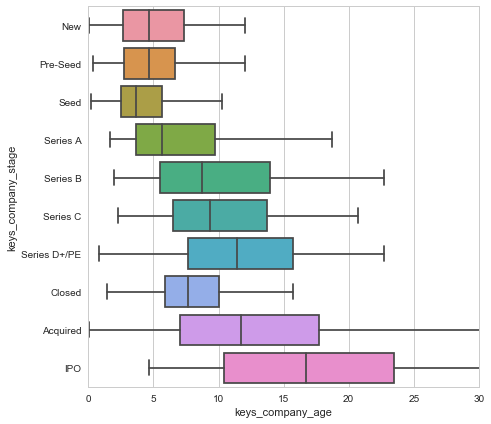

In [12]:
data = df.loc[df["keys_company_stage_group"] != "Excluded"]
order = ["New", "Pre-Seed", "Seed", "Series A", "Series B", "Series C", "Series D+/PE", "Closed", "Acquired", "IPO"]
f, ax = plt.subplots(figsize=(7, 7))
ax.set_xlim(xmax=30)
sns.boxplot(x="keys_company_age", y="keys_company_stage",order=order,data=data, fliersize=0, ax=ax)

## 4.2 Feature Extraction

In [14]:
from sklearn.preprocessing import FunctionTransformer

#create features
drops = [col for col in list(df) if col.startswith(("key","from","outcome","index"))]
X = df.drop(drops, axis=1)
X = X.select_dtypes(include=[np.number])
features = list(X)

#transform features
tlog = FunctionTransformer(np.log1p)
features_num = [col for col in features if col.endswith("number")]
X_num = df[features_num]
X_log = pd.DataFrame(tlog.transform(X_num), index=X_num.index, columns=X_num.columns)
X_log = X_log.add_suffix("_log")
df = pd.concat([df, X_log], axis=1)
features += list(X_log)

#make constraints
df = df.loc[df['keys_company_stage_group'] == "Core"]

#update X and y
X = df[features]

### 4.2.1 Missing Values

Figure 4.2 Missing features per observation (histogram).

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


[(0, 250.0)]

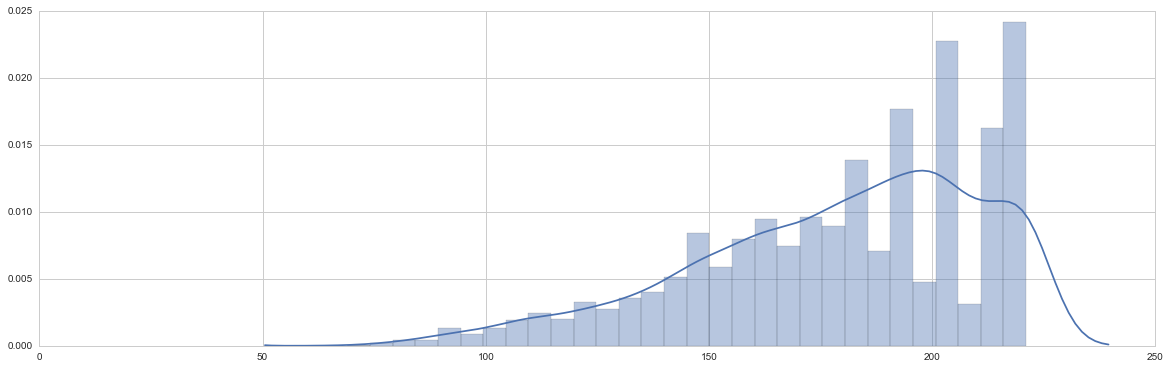

In [15]:
missing_by_row = X.isnull().sum(axis=1)
g = sns.distplot(missing_by_row)
g.set(xlim = (0,None))

Figure 4.3 Missing observations per feature (histogram).

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


[(0, 4500.0)]

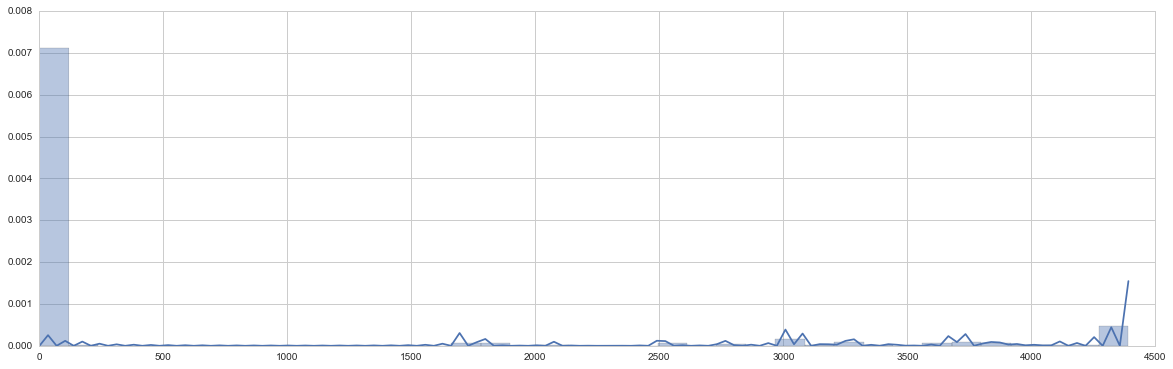

In [16]:
missing_by_col =  X.isnull().sum(axis=0)
g = sns.distplot(missing_by_col)
g.set(xlim = (0,None))

### 4.2.2 Feature Components

In [18]:
from sklearn.preprocessing import Imputer, scale, robust_scale, FunctionTransformer
from collections import defaultdict

def sum_group(row):
    col_groups = defaultdict(int)
    for feature in list(row.index):
        col_groups[feature_groups[feature]] += row[feature]
    row = pd.Series(col_groups)
    return row

feature_groups = {x:x.split("_")[2] for x in features}
X.dropna(axis=1, how='all', inplace=True)
imp = Imputer(strategy="median")
X_imp = pd.DataFrame(imp.fit_transform(X), index=X.index, columns=X.columns)
X_std = pd.DataFrame(scale(X_imp), index=X_imp.index, columns=X_imp.columns)
X_grp = X_std.apply(lambda row: sum_group(row), axis=1)
X_grp_std = pd.DataFrame(scale(X_grp), index=X_grp.index, columns=X_grp.columns)


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


ValueError: ('cannot reindex from a duplicate axis', 'occurred at index 294917')

Figure 4.4 Inter-correlations of each factor from conceptual framework (matrix).

In [179]:
print(X_grp_std.describe())

        advisors    broader  customers  executives   founders    funding  \
count  4.698e+03  4.698e+03  4.698e+03   4.698e+03  4.698e+03  4.698e+03   
mean  -1.954e-16 -4.535e-17  8.046e-17  -1.381e-16  1.654e-15  2.149e-16   
std    1.000e+00  1.000e+00  1.000e+00   1.000e+00  1.000e+00  1.000e+00   
min   -1.073e+00 -9.188e+00 -1.035e-01  -5.739e-01 -4.919e-01 -8.121e+00   
25%   -2.836e-01 -9.076e-01 -1.035e-01  -5.728e-01 -4.919e-01 -2.726e-01   
50%   -2.836e-01 -2.044e-01 -1.035e-01  -2.452e-01 -4.919e-01 -2.726e-01   
75%   -2.836e-01  6.279e-01 -1.035e-01   1.231e-01  2.341e-01 -2.726e-01   
max    9.498e+00  3.966e+00  1.893e+01   8.444e+00  1.017e+01  1.389e+01   

        industry  influence  investors      local  
count  4.698e+03  4.698e+03  4.698e+03  4.698e+03  
mean  -1.159e-16  5.862e-17  5.125e-16 -1.932e-16  
std    1.000e+00  1.000e+00  1.000e+00  1.000e+00  
min   -8.518e-01 -2.498e-01 -4.445e-01 -6.339e-01  
25%   -8.518e-01 -2.498e-01 -4.445e-01 -6.339e-01  
50%

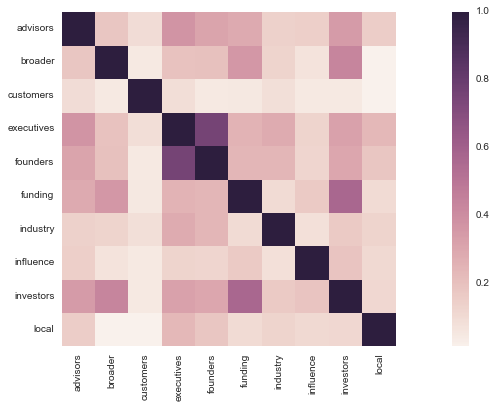

In [180]:
sns.heatmap(X_grp_std.corr(method="spearman"), square=True)

Figure 4.4 Eigenvalues extracted from PCA model (line plot).

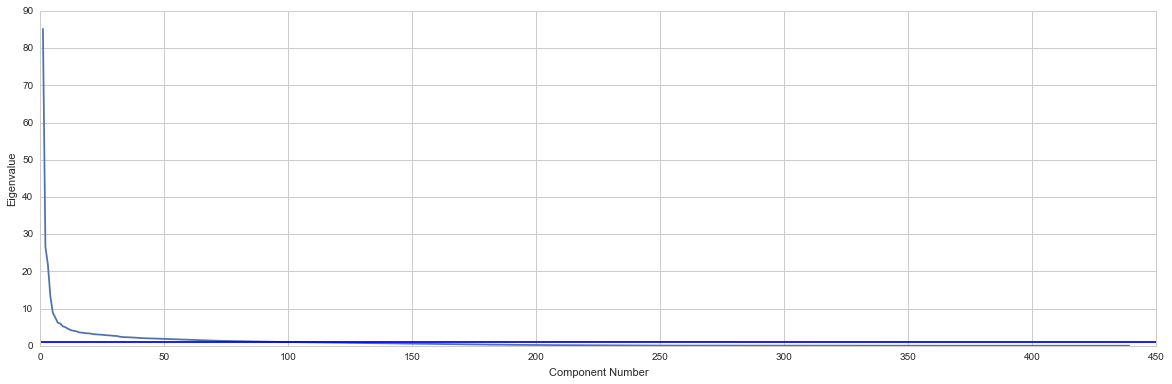

In [187]:
#Principal Components Analysis (PCA)
from sklearn.decomposition import PCA

def screeplot(pca, X_std):
    y = pca.explained_variance_
    x = np.arange(len(y)) + 1
    plt.plot(x, y)
    plt.ylabel("Eigenvalue")
    plt.xlabel("Component Number")
    plt.axhline(y=1)
    return y

pca = PCA().fit(X_std)
eigenvalues = screeplot(pca, X_std)
retained = range(0,8) #where(eigenvalues >= 1)

Figure 4.5 Component loadings on each factor from conceptual framework (matrix).

In [ ]:
groups = set([x.split("_")[2] for x in features])


    

In [191]:
from collections import defaultdict

groups = set([x.split("_")[2] for x in features])

loadings_matrix = []
for x in retained:
    loadings = pca.components_[x].T
    grp_loadings = defaultdict(int)
    for group, loading in zip(groups, loadings):
        grp_loadings[group] += loading
    loadings_matrix.append(grp_loadings)

test = defaultdict(list)
for d in loadings_matrix:
    for k,v in d.items():
        test[k].append(v)

pd.DataFrame(test).T

,0,1,2,3,4,5,6,7
advisors,-5.914e-04,-5.204e-03,-1.870e-03,-3.575e-03,9.434e-03,-0.009,0.003,-3.289e-03
broader,-2.844e-03,1.537e-03,3.324e-04,-3.271e-03,-3.278e-03,0.003,0.003,-1.280e-03
customers,8.562e-04,-8.094e-03,-4.597e-03,1.626e-03,-1.475e-03,-0.006,-0.005,-1.110e-02
executives,-5.412e-04,5.880e-04,-7.852e-03,-1.144e-02,-8.971e-04,0.003,0.004,-3.131e-03
founders,3.348e-03,5.151e-03,-7.713e-03,-7.453e-03,1.038e-02,0.011,-0.007,2.139e-04
funding,3.876e-03,6.136e-03,9.780e-03,1.749e-02,3.549e-03,0.003,-0.003,1.626e-02
industry,1.098e-03,-5.346e-03,-8.396e-03,-3.072e-03,-3.708e-03,0.009,0.011,-4.716e-03
influence,-7.023e-04,-3.021e-03,-3.273e-03,-2.007e-02,-7.164e-03,-0.004,-0.005,-1.407e-02
investors,-5.848e-03,1.600e-04,1.964e-03,4.384e-03,-5.184e-03,-0.004,0.002,-5.998e-04
local,-3.015e-03,-2.044e-03,-7.755e-04,1.005e-04,-3.476e-03,0.001,0.008,-2.903e-03


## 4.3 Classification Algorithms

Table 4.2 Classification accuracy metrics for each algorithm.

Figure 4.7 Receiver operating characteristics for each algorithm (line plot).

## 4.4 Experimentation

### 4.4.1 Practical 

Figure 4.8 AUC ROC for different training set sizes (line plot).

Table 4.3 Time profiling by system component.

### 4.4.2 Robust

Table 4.4 Comparison of 2013 slice from 2016 dataset with 2013 dataset.

Table 4.5 Features ranked by importance for different time slices.

Figure 4.9 ROC curves for models trained on different time slices (line plot).

### 4.4.3 Predictive

Table 4.6 Features ranked by importance for different prediction windows.

Figure 4.10 ROC curves for models trained on different prediction windows (line plot).

Figure 4.11 Change in company stage over different prediction windows (matrix).

Figure 4.12 ROC curves for target companies at different lifecycle stages (line plot).

Figure 4.13 AUC ROC for models by lifecyle stage and prediction window (matrix)

Table 4.7 Three example company profiles and their predictions.

# C. Conceptual Framework

Table C.1 List of included features.

# D. Additional Classifier Results

Table D.1 Hyperparameter gridsearch for each algorithm.

Table D.2 Optimal Logistic Regression model.

Figure D.1 Optimal Decision Tree model (tree).